In [1]:
import tensorflow as tf

# Tensorflow 

tensorflow에서 이번에 alpha 버전을 출시해서 경험삼아 사용해 보기로 하였다. `tensorflow-alpha`는 keras의 기능을 더 잘살려서 사용하기 편해졌고 최대한 `tensorflow-alpha`의 기능을 잘살려볼 것이다.

In [2]:
tf.__version__

'2.0.0-alpha0'

In [34]:
import os
import time 
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import clear_output

# dataset download
        
`tf.keras.util.get_file(fname,origin,extract)` 안에 매개변수가 더 있지만 내가 사용하는 것만 적었다.

- `fname` : 파일 이름
- `origin` : 파일의 URL
- `extrack` : tar또는 zip과 같이 Archive로서 파일을 추출한다.

In [4]:
map_dataset_url = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz'
map_dataset_path = tf.keras.utils.get_file('map.tar.gz',
                                      origin=map_dataset_url,
                                      extract=True)

# image read

## opencv

이미지 처리 분야에서 많이 쓰이지만 이미지가 BGR순서로 저장되기 때문에 사용하는데 제약이 있다.

## matplotlib

RGB로 읽어주는 maplot을 사용할 것이다.

# train data / test data

In [5]:
def create_dataset(path):
    train_dataset = []
    train_data_list = os.listdir(path)

    for train_data in train_data_list:   
        img = plt.imread(path + train_data)
        train_dataset.append(img)
    
    return train_dataset

In [6]:
PATH = os.path.join(os.path.dirname(map_dataset_path), r'maps/')
print(PATH)

C:\Users\woals\.keras\datasets\maps/


In [7]:
train_dataset = create_dataset(PATH + 'train/')

In [8]:
test_dataset = create_dataset(PATH + 'val/')

# Sample

(600, 1200, 3)


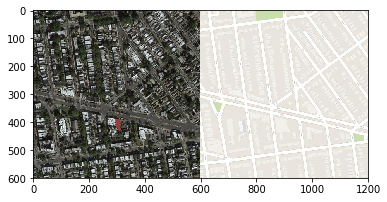

In [10]:
# 이미지 하나를 꺼내서 읽는다
plt.imshow(train_dataset[0])
print(train_dataset[0].shape)

# preprocessing

- 이미지의 가로를 기준으로 2등분해서 이미지를 나누어 준다.
- 실제 지도 이미지가 `input`이 될 것이다.
- 그림 지도 이미지가 `target`이 될 것이다.
- 실제 지도 -> 그림 지도

## tensorflow datatype
- tensorflow datatype으로 형변환 해야한다. `tf.cast(input,type)`


## input normalization
- input 이미지의 pixel값을 -1 ~ 1로 정규화 시켜서 학습을 더 잘되게 한다. 값이 퍼지는 것을 모아주고 시작한다고 이해하면 쉬울거 같다.

In [11]:
def split_image(img):
    tmp = np.split(img,2,axis=1)
    img_A = tmp[0]
    img_B = tmp[1]

    return img_A,img_B

In [12]:
def normalize(img):
    img = (img / 127.5) - 1

    return img

In [13]:
def resize(img,h,w):
    img = tf.image.resize(img,[h,w],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return img

변환전 datatype :  uint8
변환후 datatype :  <dtype: 'float32'>


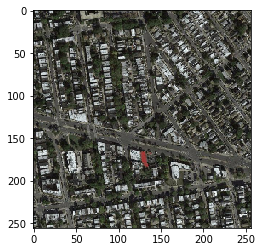

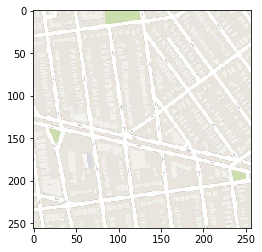

In [14]:
input_, target_ = split_image(train_dataset[0])

print("변환전 datatype : ",input_.dtype)

# tensorflow datatype으로 형변환
input_ = tf.cast(input_, tf.float32)
target_ = tf.cast(target_,tf.float32)

input_ = resize(input_,256,256)
target_ = resize(target_,256,256)

print("변환후 datatype : ",input_.dtype)

plt.figure()
plt.imshow(input_/255.0)
plt.figure()
plt.imshow(target_/255.0)

# Model

생성자는 학습을 거듭할 때 마다 진짜 그림 이미지 같이 만들고 싶어하고 구별자는 누가 가짜인지 진짜인지 잘 구분해 하고 싶기 때문에 둘이 적대적인 관계를 유지합니다. 이것이 GAN을 적대적 생성 모델이라고 부르는 이유 입니다.

In [15]:
def encoding(filters, size, apply_batchnorm=True):
    # 가중치 초기화
    initializer = tf.random_normal_initializer(0.,0.02)
    # 모델생성
    model = tf.keras.Sequential()
    # 모델에 추가
    # Convolution 을 이용해 이미지를 downsampling 한다
    model.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # 모델에 batch normalization 추가
    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    
    # 활성화 함수 LeakyRelu
    model.add(tf.keras.layers.LeakyReLU())

    return model

In [16]:
down_model = encoding(3, 4)
down_result = down_model(tf.expand_dims(input_, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [17]:
def decoding(filters, size, apply_dropout=False):
    # 가중치 초기화
    initializer = tf.random_normal_initializer(0., 0.02)
    # 모델 생성
    model = tf.keras.Sequential()
    # 모델에 추가
    # Convolution Transpose를 이용해서 upsampling 한다
    model.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    # 모델에 batch normalization 추가
    model.add(tf.keras.layers.BatchNormalization())

    # Dropout 추가
    if apply_dropout:
        model.add(tf.keras.layers.Dropout(0.5))

    # 활성화 함수 relu 
    model.add(tf.keras.layers.ReLU())

    return model

In [18]:
up_model = decoding(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


## Generator



![generate](./generate.PNG)



생성자는 실제 지도 이미지를 입력 받았을 때 그림 지도 이미지를 생성해주는 생성자입니다. `encoder-decoder` 구조를 가지는 모델 입니다.

이미지 출처 : [https://affinelayer.com/pix2pix/](https://affinelayer.com/pix2pix/)


In [19]:
def Generator():
    encoder = [
        encoding(64, 4, apply_batchnorm=False), # (?, 128, 128, 64)
        encoding(128, 4), # (?, 64, 64, 128)
        encoding(256, 4), # (?, 32, 32, 256)
        encoding(512, 4), # (?, 16, 16, 512)
        encoding(512, 4), # (?, 8, 8, 512)
        encoding(512, 4), # (?, 4, 4, 512)
        encoding(512, 4), # (?  2, 2, 512)
        encoding(512, 4), # (?, 1, 1, 512)
    ]
    
    decoder = [
        decoding(512, 4, apply_dropout=True), # (?, 2, 2, 1024)
        decoding(512, 4, apply_dropout=True), # (?, 4, 4, 1024)
        decoding(512, 4, apply_dropout=True), # (?, 8, 8, 1024)
        decoding(512, 4), # (?, 16, 16, 1024)
        decoding(256, 4), # (?, 32, 32, 512)
        decoding(128, 4), # (?, 64, 64, 256)
        decoding(64, 4),  # (?, 128, 128, 128)
    ]
    
    # 가중치 초기화
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # 마지막 output layer
    output_layer = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (?, 256, 256, 3)
    
    # concat layer
    concat = tf.keras.layers.Concatenate()
    
    # inputs
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    
    # encoding start
    # skip은 decoder를 진행할때 도움을 주는 layer다.
    skips = []
    for encode in encoder:
        x = encode(x)
        skips.append(x)
    
    # encoder의 마지막 layer는 decoder에 넘겨주는 부분이기 때문에 제외
    skips = reversed(skips[:-1]) 
    
    # decoding start
    # concat는 두 리스트를 합쳐준다.
    for decode,skip in zip(decoder,skips):
        x = decode(x)
        x = concat([x,skip])
        
    x = output_layer(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

## Discriminator



![discriminator](./discriminator.PNG)




구별자는 그림 지도 이미지와 `Generator`가 만들어낸 그림 지도 이미지중에 뭐가 진짜인지 찾아내는 모델 입니다.

이미지 출처 : [https://affinelayer.com/pix2pix/](https://affinelayer.com/pix2pix/)


In [20]:
def Discriminator():
    # 가중치 초기화
    initializer = tf.random_normal_initializer(0., 0.02)
    
    
    input_ = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    target_ = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([input_, target_]) # (?, 256, 256, channels*2)

    # encoding start
    down1 = encoding(64, 4, False)(x) # (?, 128, 128, 64)
    down2 = encoding(128, 4)(down1) # (?, 64, 64, 128)
    down3 = encoding(256, 4)(down2) # (?, 32, 32, 256)

    # pad 추가
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (?, 34, 34, 256)
    
    # stride가 1인 convolution 통과시키기
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (?, 31, 31, 512)

    # Batch normalization
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    # 활성화 함수 leaky relu
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    # pad 추가
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (?, 33, 33, 512)

    # stride가 1인 convolution 통과시키기
    outputs = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (?, 30, 30, 1)

    return tf.keras.Model(inputs=[input_, target_], outputs=outputs)

In [21]:
generator = Generator()
discriminator = Discriminator()

# Loss 

In [22]:
LAMBDA = 100

In [23]:
cost = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(D_real, D_fake):
    # 진짜는 1
    real_loss = cost(tf.ones_like(D_real), D_real)
    
    # 가짜는 0
    generated_loss = cost(tf.zeros_like(D_fake), D_fake)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [25]:
def generator_loss(D_fake, G_, target):
    # 가짜(생성된 이미지)는 1
    gan_loss = cost(tf.ones_like(D_fake), D_fake)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - G_))
    # L1 loss를 포함한다.
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

# Optimizer

In [26]:
G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Train

In [27]:
def preprocessing(train_data):
    input_, target_ = split_image(train_data)
        
    input_ = tf.cast(input_, tf.float32)
    target_ = tf.cast(target_,tf.float32)
    
    input_ = tf.image.resize(input_,[256,256])
    target_ = tf.image.resize(target_,[256,256])
    
    input_ = normalize(input_)
    target_ = normalize(target_)
    
    input_ = input_[tf.newaxis,...]
    target_ = target_[tf.newaxis,...]
    
    return input_,target_

In [28]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(G_optimizer=G_optimizer,
                                 D_optimizer=D_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
EPOCHS = 100

train_data_len = len(train_dataset)

g_loss_seq = []
d_loss_seq = []

for epoch in range(EPOCHS):
    for i,train_data in enumerate(train_dataset):
        input_, target_ = preprocessing(train_data)

        input_ = tf.cast(input_, tf.float32)
        target_ = tf.cast(target_,tf.float32)

        # 직접 gradient 업데이트
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            G_ = generator(input_,training=True)

            D_real = discriminator([input_,target_],training=True)
            D_fake = discriminator([input_,G_],training=True)

            G_cost = generator_loss(D_fake,G_,target_)
            D_cost = discriminator_loss(D_real, D_fake)

        G_gradients = g_tape.gradient(G_cost,generator.trainable_variables)
        D_gradients = d_tape.gradient(D_cost,discriminator.trainable_variables)

        G_optimizer.apply_gradients(zip(G_gradients,
                                       generator.trainable_variables))

        D_optimizer.apply_gradients(zip(D_gradients,
                                       discriminator.trainable_variables))
    
        print("[EPOCH : {}/{} | ITER : {}/{} | G_loss :{} | D_loss : {}]".format(epoch,EPOCHS,i,train_data_len,G_cost,D_cost))
        
        g_loss_seq.append(G_cost)
        d_loss_seq.append(D_cost)
        
        #generate_images(generator, input_, target_)
        
        clear_output(wait=True)

    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)


[EPOCH : 2/100 | ITER : 441/1096 | G_loss :8.389012336730957 | D_loss : 0.48615747690200806]


In [35]:
for test_data in test_dataset:
    input_, target_ = preprocessing(test_data)
    generate_images(generator, input_, target_)
    clear_output(wait=True)

KeyboardInterrupt: 